In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [2]:
df = pd.read_csv('NSE-TATA.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [3]:
df['Date'] = pd.to_datetime(df.Date, format = '%Y-%m-%d')
df.index = df['Date']

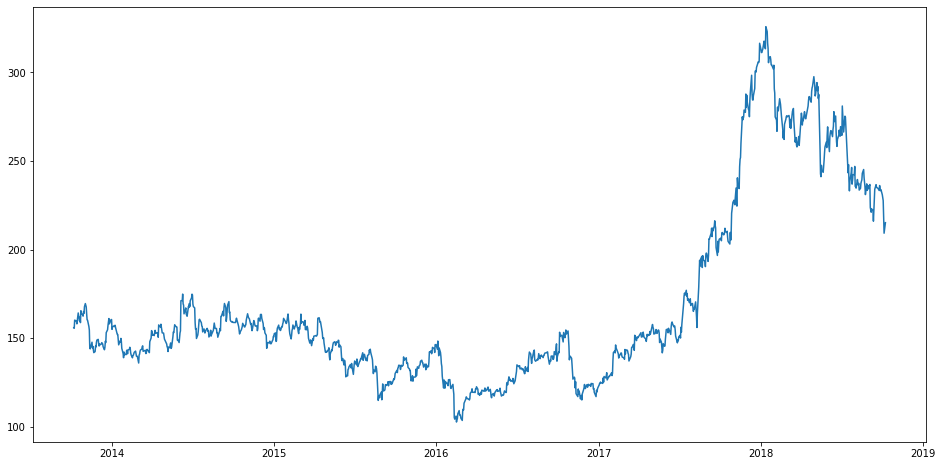

In [4]:
plt.figure(figsize = (16,8))
plt.plot(df['Close'], label = 'Close Price history')

In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

data = df.sort_index(ascending = True, axis=0)
new_dataset = pd.DataFrame(index = range(0,len(df)), columns = ['Date','Close'])

In [6]:
for i in range(0,len(data)):
    new_dataset['Date'][i] = data['Date'][i]
    new_dataset['Close'][i] = data['Close'][i]
    
new_dataset.index = new_dataset.Date
new_dataset.drop('Date',axis = 1, inplace = True)

In [7]:
final_dataset = new_dataset.values

train_data = final_dataset[0:987,:]
valid_data = final_dataset[987:,:]

scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(final_dataset)

In [10]:
x_train_data, y_train_data = [],[]

for i in range(60, len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

In [12]:
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)

x_train_data = np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [15]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

2022-09-20 22:37:55.843316: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=50,batch_size=4,verbose=2)

Epoch 1/50
232/232 - 9s - loss: 0.0012 - 9s/epoch - 38ms/step
Epoch 2/50
232/232 - 6s - loss: 6.5977e-04 - 6s/epoch - 26ms/step
Epoch 3/50
232/232 - 6s - loss: 4.7459e-04 - 6s/epoch - 25ms/step
Epoch 4/50
232/232 - 6s - loss: 4.3887e-04 - 6s/epoch - 27ms/step
Epoch 5/50
232/232 - 6s - loss: 3.5013e-04 - 6s/epoch - 24ms/step
Epoch 6/50
232/232 - 6s - loss: 3.0342e-04 - 6s/epoch - 27ms/step
Epoch 7/50
232/232 - 6s - loss: 2.8100e-04 - 6s/epoch - 26ms/step
Epoch 8/50
232/232 - 6s - loss: 2.4286e-04 - 6s/epoch - 28ms/step
Epoch 9/50
232/232 - 5s - loss: 2.2081e-04 - 5s/epoch - 23ms/step
Epoch 10/50
232/232 - 6s - loss: 2.4224e-04 - 6s/epoch - 25ms/step
Epoch 11/50
232/232 - 6s - loss: 1.9503e-04 - 6s/epoch - 26ms/step
Epoch 12/50
232/232 - 6s - loss: 2.0923e-04 - 6s/epoch - 26ms/step
Epoch 13/50
232/232 - 8s - loss: 2.0899e-04 - 8s/epoch - 36ms/step
Epoch 14/50
232/232 - 7s - loss: 1.8186e-04 - 7s/epoch - 31ms/step
Epoch 15/50
232/232 - 6s - loss: 2.0452e-04 - 6s/epoch - 27ms/step
Epoch 16

In [17]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

In [18]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

In [20]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

/var/folders/4j/ry7_scw962q90x2629f31m2m0000gn/T/ipykernel_6430/2310102264.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


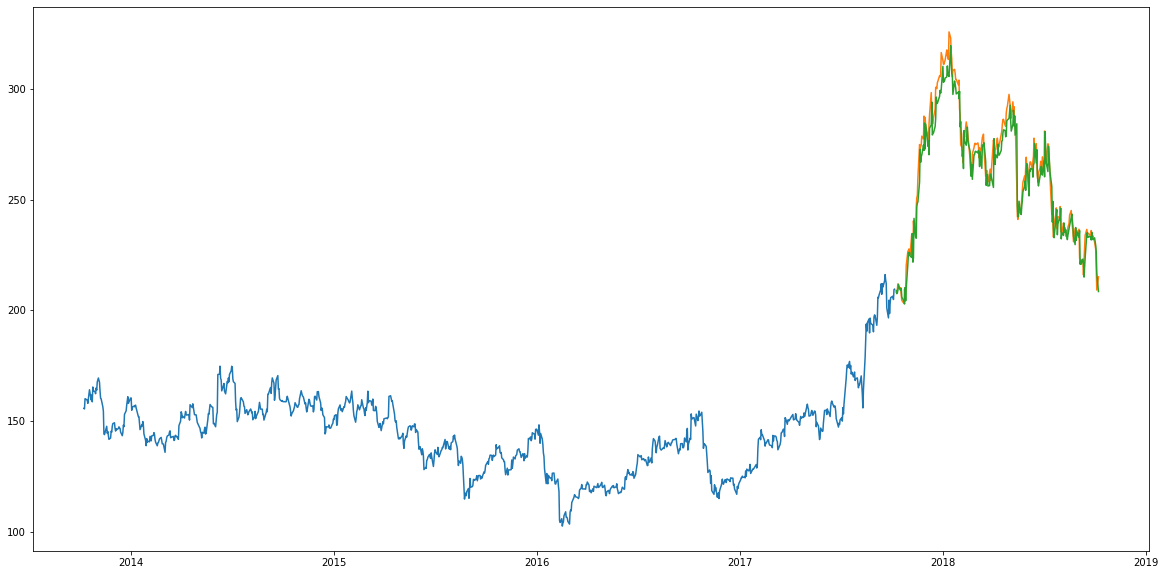

In [22]:
lstm_model.save("saved_lstm_model.h5")

train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])